In [1]:
import numpy as np
import nibabel as nib
from ipywidgets import interact, interactive, IntSlider, ToggleButtons
import matplotlib.pyplot as plt
from skimage.util import montage
from skimage.transform import rotate

%matplotlib inline
import seaborn as sns
from tensorflow.keras import backend as K
#import keras.backend as K
from tensorflow import keras 
from tensorflow.keras.callbacks import CSVLogger
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard, LearningRateScheduler 
from tensorflow.keras.layers.experimental import preprocessing
import cv2
import random 

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Define the parameters

In [2]:
IMG_SIZE=128
IMG_START_AT=56 # we will crop the images 
IMG_STOP_AT = 184
# there are 155 slices per volume
# to start at 5 and use 145 slices means we will skip the first 5 and last 5
VOLUME_SLICES = 128
VOLUME_START_AT = 13 # first slice of volume that we will include
SEGMENT_CLASSES = {
    0 : 'NOT tumor',
    1 : 'NECROTIC/CORE', # or NON-ENHANCING tumor CORE
    2 : 'EDEMA',
    3 : 'ENHANCING' # original 4 -> converted into 3 later
}
MODALITIES = 2 # FLAIR and T1CE
CLASSES = 4 
EPOCHS = 20
BATCH_SIZE = 1
LR = 1e-03

## Extract the dataset

In [3]:
import tarfile
file = tarfile.open('/kaggle/input/brats-2021-task1/BraTS2021_Training_Data.tar')

file.extractall('./brain_images')
file.close()

In [4]:
TRAIN_DATASET_PATH = './brain_images'

file = tarfile.open('/kaggle/input/brats-2021-task1/BraTS2021_00621.tar')
file.extractall('./val_brain_images')
file.close()

In [5]:
VALIDATION_DATASET_PATH = '../val_brain_images'

In [6]:
import os
train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]

In [7]:
def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

train_and_test_ids = pathListIntoIds(train_and_val_directories);


train_test_ids, val_ids = train_test_split(train_and_test_ids,test_size=0.2)
train_ids, test_ids = train_test_split(train_test_ids,test_size=0.15)

## Define our own metrics

In [8]:
# dice loss as defined above for 4 classes
def dice_coef(y_true, y_pred, epsilon=0.00001):
    """
    Dice = (2*|X & Y|)/ (|X|+ |Y|)
         =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
    ref: https://arxiv.org/pdf/1606.04797v1.pdf

    """
    axis = (0,1,2,3)
    dice_numerator = 2. * K.sum(y_true * y_pred, axis=axis) + epsilon
    dice_denominator = K.sum(y_true*y_true, axis=axis) + K.sum(y_pred*y_pred, axis=axis) + epsilon
    return K.mean((dice_numerator)/(dice_denominator))



# define per class evaluation of dice coef
# inspired by https://github.com/keras-team/keras/issues/9395
def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[0,:,:,:,1] * y_pred[0,:,:,:,1]))
    return (2. * intersection) / (K.sum(K.square(y_true[0,:,:,:,1])) + K.sum(K.square(y_pred[0,:,:,:,1])) + epsilon)

def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[0,:,:,:,2] * y_pred[0,:,:,:,2]))
    return (2. * intersection) / (K.sum(K.square(y_true[0,:,:,:,2])) + K.sum(K.square(y_pred[0,:,:,:,2])) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[0,:,:,:,3] * y_pred[0,:,:,:,3]))
    return (2. * intersection) / (K.sum(K.square(y_true[0,:,:,:,3])) + K.sum(K.square(y_pred[0,:,:,:,3])) + epsilon)

# Computing Precision
def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision


# Computing Sensitivity
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


# Computing Specificity
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

## Create batch data

In [9]:
keras = tf.compat.v1.keras
Sequence = keras.utils.Sequence
from sklearn.preprocessing import MinMaxScaler

class DataGenerator(Sequence):
    'Generates image data in batches and the function to access to it.'
    def __init__(self, list_IDs, dim=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, n_channels=MODALITIES, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generates one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # Find list of IDs
        Batch_ids = [self.list_IDs[k] for k in indexes]
        # Generate data
        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch. '
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        'Generates data containing batch_size samples and makes the preprocessing (cropping, one hot encoding and normalization).' 
        # Initialization
        X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size*VOLUME_SLICES, IMG_SIZE, IMG_SIZE))
        # Generate data
        for c, i in enumerate(Batch_ids):
            case_path = os.path.join(TRAIN_DATASET_PATH, i)

            data_path = os.path.join(case_path, f'{i}_flair.nii.gz');
            flair = nib.load(data_path).get_fdata()

            data_path = os.path.join(case_path, f'{i}_t1ce.nii.gz');
            ce = nib.load(data_path).get_fdata()

            data_path = os.path.join(case_path, f'{i}_seg.nii.gz');
            seg = nib.load(data_path).get_fdata()

            # Select the wanted slices and crop the images 
            for j in range(VOLUME_SLICES):
                X[j+(VOLUME_SLICES*c), :, :,0] = cv2.resize(flair[IMG_START_AT:IMG_START_AT+IMG_STOP_AT, IMG_START_AT:IMG_START_AT+IMG_STOP_AT,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
                X[j+(VOLUME_SLICES*c),:,:,1] = cv2.resize(ce[IMG_START_AT:IMG_START_AT+IMG_STOP_AT, IMG_START_AT:IMG_START_AT+IMG_STOP_AT, j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
                y[j +VOLUME_SLICES*c,:,:] = cv2.resize(seg[IMG_START_AT:IMG_START_AT+IMG_STOP_AT,IMG_START_AT:IMG_START_AT+IMG_STOP_AT,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
        X = X.reshape(self.batch_size,VOLUME_SLICES,IMG_SIZE,IMG_SIZE, MODALITIES)
        y = y.reshape(self.batch_size,VOLUME_SLICES,IMG_SIZE,IMG_SIZE)
        
        # Generate masks
        y[y==4] = 3 # set to 3 the label 4 (3 is unused)
        y = tf.one_hot(y, CLASSES) # shape (IMG_SIZE, IMG_SIZE, VOLUME_SLICES, CLASSES) for categorical BCE loss
        
        # Reshape the data to (num_samples, num_voxels)
        reshaped_data = X.reshape((self.batch_size*VOLUME_SLICES*IMG_SIZE*IMG_SIZE, MODALITIES))
        
        # Normalize with MinMaxScaler 
        scaler = MinMaxScaler()
        normalized_data = scaler.fit_transform(reshaped_data)
        
        # Reshape the normalized data back to its original shape
        X_norm = normalized_data.reshape((self.batch_size,VOLUME_SLICES,IMG_SIZE,IMG_SIZE, MODALITIES))

        return X_norm, y

training_generator = DataGenerator(train_ids)
valid_generator = DataGenerator(val_ids)
test_generator = DataGenerator(test_ids)

## Define the model

In [10]:
def conv_block(input_mat,num_filters,kernel_size,batch_norm):
    X = Conv3D(num_filters,kernel_size=(kernel_size,kernel_size,kernel_size),strides=(1,1,1),padding='same')(input_mat)
    if batch_norm:
        X = BatchNormalization()(X)

    X = keras.layers.PReLU()(X)

    X = Conv3D(num_filters,kernel_size=(kernel_size,kernel_size,kernel_size),strides=(1,1,1),padding='same')(X)
    if batch_norm:
        X = BatchNormalization()(X)

    X = keras.layers.PReLU()(X)

    X = add([input_mat,X]);

    return X

In [11]:
def Vnet_3d(input_img, dropout = 0.2, batch_norm = True):
    '''Defines the V-net CNN that will allow us to make the segmentation.
    Parameters
    input_img: keras.Input of size (VOLUME_SLICES, IMG_SIZE, IMG_SIZE, MODALITIES) 
    dropout: probability of setting coefficients randomly to zero
    batch_norm: re-centering or not the layers. 
    
    Returns: V-net keras model
    '''
  
    c1 = Conv3D(8,kernel_size = (5,5,5) , strides = (1,1,1) , padding='same')(input_img)
  
    c2 = Conv3D(16,kernel_size = (2,2,2) , strides = (2,2,2) , padding = 'same' )(c1)
    c3 = conv_block(c2 , 16,5,True)
  
    p3 = Conv3D(32,kernel_size = (2,2,2) , strides = (2,2,2), padding = 'same')(c3)
    p3 = Dropout(dropout)(p3)
    c4 = conv_block(p3, 32,5,True)
  
    p4 = Conv3D(64,kernel_size = (2,2,2) , strides = (2,2,2) , padding='same')(c4)
    p4 = Dropout(dropout)(p4)
    c5 = conv_block(p4, 64,5,True)
  
    a5 = Conv3D(128,kernel_size = (2,2,2) , strides = (2,2,2) , padding='same')(c5)
    a5 = Dropout(dropout)(a5)
    d5 = conv_block(a5, 128,5,True)
  
    s6 = Conv3D(256,kernel_size = (2,2,2) , strides = (2,2,2) , padding='same')(d5)
    s6 = Dropout(dropout)(s6)
    d6 = conv_block(s6, 256,5,True)
  
    p6 = Conv3D(512,kernel_size = (2,2,2) , strides = (2,2,2) , padding='same')(d6)
    p6 = Dropout(dropout)(p6)
    p7 = conv_block(p6,512,5,True)
  
    s5 = Conv3DTranspose(256, (2,2,2), strides=(2, 2, 2), padding='same')(p7);
    s5 = concatenate([s5,d6]);
    t7 = conv_block(s5,512,5,True)
    t7 = Dropout(dropout)(t7)
  
    a6 = Conv3DTranspose(128, (2,2,2), strides=(2, 2, 2), padding='same')(t7);
    a6 = concatenate([a6,d5]);
    d7 = conv_block(a6,256,5,True)
    d7 = Dropout(dropout)(d7)
  
    u6 = Conv3DTranspose(64, (2,2,2), strides=(2, 2, 2), padding='same')(d7);
    u6 = concatenate([u6,c5]);
    c7 = conv_block(u6,128,5,True)
    c7 = Dropout(dropout)(c7)
  
    u7 = Conv3DTranspose(32,(2,2,2),strides = (2,2,2) , padding= 'same')(c7);
    u8 = concatenate([u7,c4]);
    c8 = conv_block(u8,64,5,True)
    c8 = Dropout(dropout)(c8)
  
    u9 = Conv3DTranspose(16,(2,2,2),strides = (2,2,2) , padding= 'same')(c8);
    u9 = concatenate([u9,c3]);
    c9 = conv_block(u9,32,5,True)
    c9 = Dropout(dropout)(c9)
  
    u10 = Conv3DTranspose(8,(2,2,2),strides = (2,2,2) , padding= 'same')(c9);
    u10 = concatenate([u10,c1]);
    c10 = Conv3D(16,kernel_size = (5,5,5),strides = (1,1,1) , padding = 'same')(u10);
    c10 = Dropout(dropout)(c10)
    c10 = add([c10,u10]);
    
    outputs = Conv3D(4, (1,1,1), activation='softmax')(c10)
  
    model = Model(inputs=input_img, outputs=outputs)
  
    return model

In [12]:
csv_logger = CSVLogger('training.log', separator=',', append=False)


callbacks = [keras.callbacks.EarlyStopping(monitor='loss', min_delta=0,
                               patience=2, verbose=1, mode='auto'),
      keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.0001, verbose=1),
      keras.callbacks.ModelCheckpoint(filepath = 'model_.{epoch:02d}-{val_loss:.6f}.m5',
                             verbose=1, save_best_only=True, save_weights_only = True),
      csv_logger
    ]

In [13]:
input_layer = Input((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, MODALITIES))

def lr_decay(epoch, initial_lr=LR, decay_factor=0.95):
    return initial_lr * np.power(decay_factor, epoch)

# Create a LearningRateScheduler callback
lr_decay_callback = LearningRateScheduler(lambda epoch: lr_decay(epoch))

# Define our implementation of V-net
model1 = Vnet_3d(input_layer)
model1.compile(loss=keras.losses.CategoricalCrossentropy(), optimizer=Adam(learning_rate=LR), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic,dice_coef_edema ,dice_coef_enhancing] )
model1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                28, 2)]                                                           
                                                                                                  
 conv3d (Conv3D)                (None, 128, 128, 12  2008        ['input_1[0][0]']                
                                8, 8)                                                             
                                                                                                  
 conv3d_1 (Conv3D)              (None, 64, 64, 64,   1040        ['conv3d[0][0]']                 
                                16)                                                           

## Dataset examples

(128, 128, 128)


Text(0.5, 1.0, 'Mask')

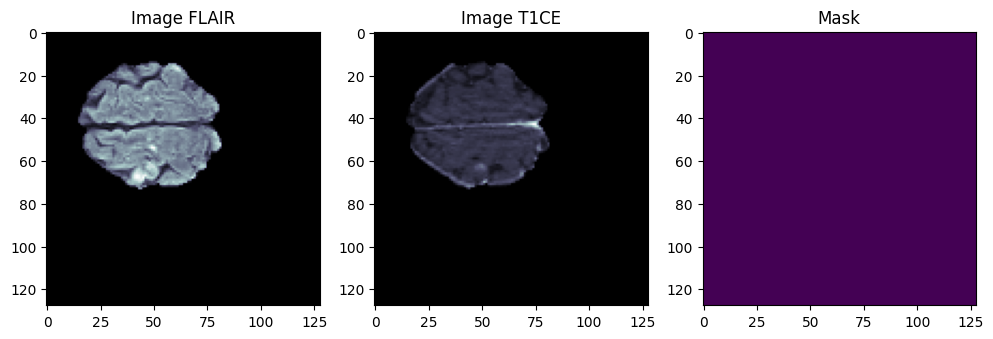

In [14]:
# Plot input data and mask
index = 10
n_slice=random.randint(0, VOLUME_SLICES)
X_train = training_generator.__getitem__(index)[0][0]
y_train = training_generator.__getitem__(index)[1][0]
flatten_y_train = np.argmax(y_train, axis=-1)
print(flatten_y_train.shape)
plt.figure(figsize=(12, 8))
plt.subplot(131)
plt.imshow(X_train[n_slice, :, :, 0], cmap='bone')
plt.title('Image FLAIR')
plt.subplot(132)
plt.imshow(X_train[n_slice, :, :, 1], cmap='bone')
plt.title('Image T1CE')
plt.subplot(133)
plt.imshow(flatten_y_train[n_slice, :, :])
plt.title('Mask')


### Train the model

In [15]:
STEPS_PER_EPOCH = len(training_generator)//BATCH_SIZE

# Train the CNN
history =  model1.fit(training_generator,
                     epochs=EPOCHS,
                     steps_per_epoch=STEPS_PER_EPOCH ,
                      batch_size=BATCH_SIZE, 
                     validation_data = valid_generator, 
                      callbacks=[lr_decay_callback]
                     )

model1.save("weights_vnet.h5") # Save the weights 

Epoch 1/20
850/850 [==============================] - 954s 1s/step - loss: 0.0661 - accuracy: 0.9809 - mean_io_u: 0.4326 - dice_coef: 0.4985 - precision: 0.9853 - sensitivity: 0.9761 - specificity: 0.9955 - dice_coef_necrotic: 0.1846 - dice_coef_edema: 0.4743 - dice_coef_enhancing: 0.3420 - val_loss: 1.2316 - val_accuracy: 0.8042 - val_mean_io_u: 0.3770 - val_dice_coef: 0.3443 - val_precision: 0.8315 - val_sensitivity: 0.7918 - val_specificity: 0.9464 - val_dice_coef_necrotic: 0.0723 - val_dice_coef_edema: 0.2515 - val_dice_coef_enhancing: 0.1572 - lr: 0.0010
Epoch 2/20
850/850 [==============================] - 933s 1s/step - loss: 0.0443 - accuracy: 0.9862 - mean_io_u: 0.4081 - dice_coef: 0.5828 - precision: 0.9898 - sensitivity: 0.9831 - specificity: 0.9966 - dice_coef_necrotic: 0.2457 - dice_coef_edema: 0.5716 - dice_coef_enhancing: 0.5174 - val_loss: 0.0910 - val_accuracy: 0.9731 - val_mean_io_u: 0.3771 - val_dice_coef: 0.4986 - val_precision: 0.9832 - val_sensitivity: 0.9670 - va

### Plot loss history

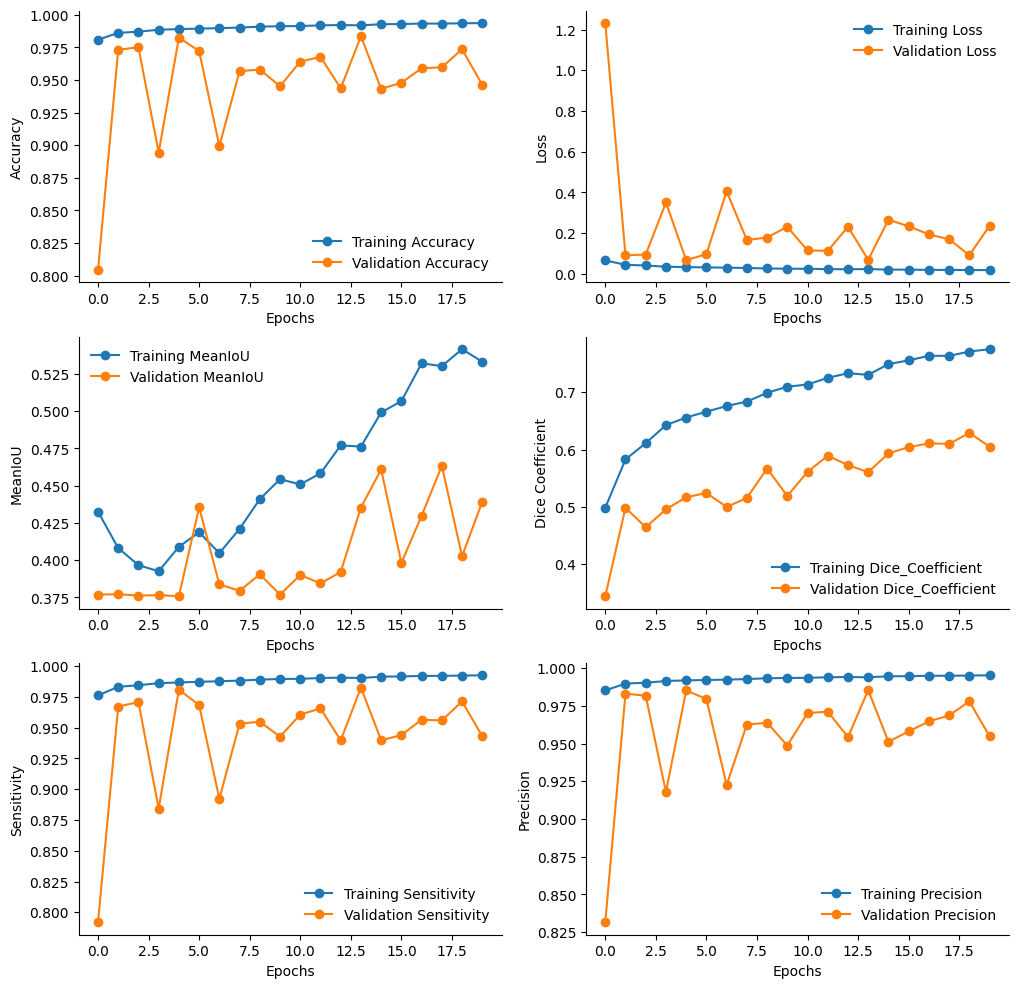

In [16]:
import matplotlib.pyplot as plt
from warnings import filterwarnings
filterwarnings('ignore')

epochs = [i for i in range(EPOCHS)]
fig, ax = plt.subplots(3,2,figsize=(12,12))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
train_mean_iou = history.history['mean_io_u']
val_mean_iou = history.history['val_mean_io_u']
train_dice_coef = history.history['dice_coef']
val_dice_coef = history.history['val_dice_coef']
train_sensitivity = history.history['sensitivity']
val_sensitivity = history.history['val_sensitivity']
train_precision = history.history['precision']
val_precision = history.history['val_precision']

sns.despine()
ax[0,0].plot(epochs, train_acc, marker='o',
           label = 'Training Accuracy')
ax[0,0].plot(epochs, val_acc, marker='o',
           label = 'Validation Accuracy')
ax[0,0].legend(frameon=False)
ax[0,0].set_xlabel('Epochs')
ax[0,0].set_ylabel('Accuracy')

sns.despine()
ax[0,1].plot(epochs, train_loss, marker='o',
           label ='Training Loss')
ax[0,1].plot(epochs, val_loss, marker='o',
           label = 'Validation Loss')
ax[0,1].legend(frameon=False)
ax[0,1].set_xlabel('Epochs')
ax[0,1].set_ylabel('Loss')

sns.despine()
ax[1,0].plot(epochs, train_mean_iou, marker='o',
           label = 'Training MeanIoU')
ax[1,0].plot(epochs, val_mean_iou, marker='o',
           label = 'Validation MeanIoU')
ax[1,0].legend(frameon=False)
ax[1,0].set_xlabel('Epochs')
ax[1,0].set_ylabel('MeanIoU')

sns.despine()
ax[1,1].plot(epochs, train_dice_coef, marker='o',
           label = 'Training Dice_Coefficient')
ax[1,1].plot(epochs, val_dice_coef, marker='o',
           label = 'Validation Dice_Coefficient')
ax[1,1].legend(frameon=False)
ax[1,1].set_xlabel('Epochs')
ax[1,1].set_ylabel('Dice Coefficient')

sns.despine()
ax[2,0].plot(epochs, train_sensitivity, marker='o',
           label = 'Training Sensitivity')
ax[2,0].plot(epochs, val_sensitivity, marker='o',
           label = 'Validation Sensitivity')
ax[2,0].legend(frameon=False)
ax[2,0].set_xlabel('Epochs')
ax[2,0].set_ylabel('Sensitivity')

sns.despine()
ax[2,1].plot(epochs, train_precision, marker='o',
           label = 'Training Precision')
ax[2,1].plot(epochs, val_precision, marker='o',
           label = 'Validation Precision')
ax[2,1].legend(frameon=False)
ax[2,1].set_xlabel('Epochs')
ax[2,1].set_ylabel('Precision')
fig.show()

### Evaluate the trained model on the test dataset

In [17]:
print("Evaluate on test data")
results = model1.evaluate(test_generator)
print("test loss, test acc:", results)

Evaluate on test data
150/150 [==============================] - 91s 602ms/step - loss: 0.2287 - accuracy: 0.9473 - mean_io_u: 0.4354 - dice_coef: 0.6226 - precision: 0.9554 - sensitivity: 0.9438 - specificity: 0.9856 - dice_coef_necrotic: 0.3511 - dice_coef_edema: 0.5724 - dice_coef_enhancing: 0.5914
test loss, test acc: [0.22869160771369934, 0.9473270773887634, 0.4354207515716553, 0.6225844621658325, 0.955417275428772, 0.9437933564186096, 0.985641598701477, 0.35108551383018494, 0.572381854057312, 0.5914347767829895]


### Show visual results on the test dataset

(128, 128, 128, 4)
1/1 [==============================] - 1s 860ms/step


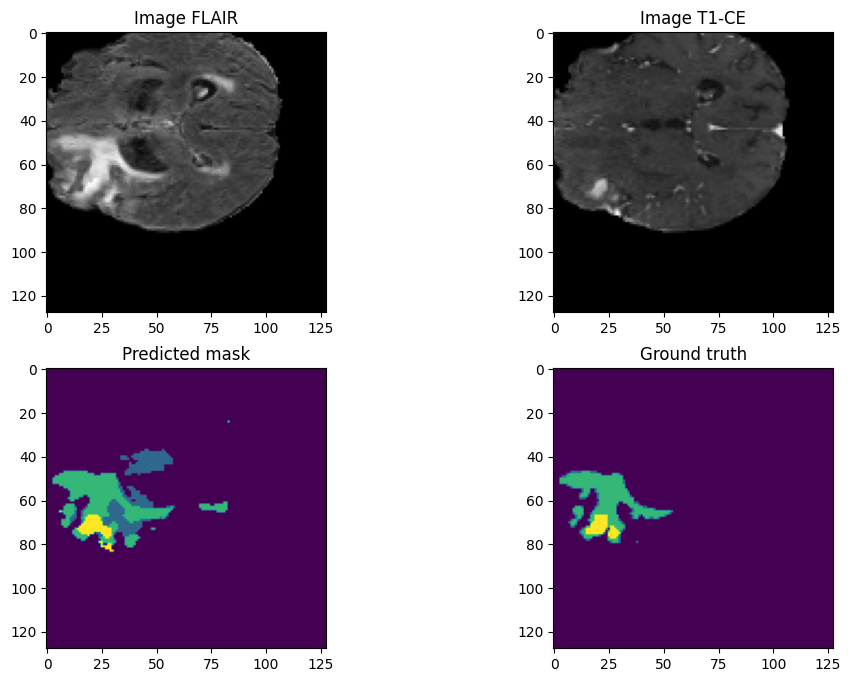

In [18]:
index = 10
n_slice=random.randint(0, VOLUME_SLICES)
X_test = test_generator.__getitem__(index)[0][0]
y_test = test_generator.__getitem__(index)[1][0]
print(y_test.shape)
flatten_y_test = np.argmax(y_test, axis=-1)

y_pred = model1.predict(np.expand_dims(X_test, axis=0))
flatten_predicted = np.argmax(y_pred, axis=-1)
flatten_predicted = np.reshape(flatten_predicted, (VOLUME_SLICES, IMG_SIZE, IMG_SIZE))

plt.figure(figsize=(12, 8))
plt.subplot(221)
plt.imshow(X_test[n_slice, :, :, 0], cmap='gray')
plt.title('Image FLAIR')
plt.subplot(222)
plt.imshow(X_test[n_slice, :, :, 1], cmap='gray')
plt.title('Image T1-CE')
plt.subplot(223)
plt.imshow(flatten_predicted[n_slice, :, :])
plt.title('Predicted mask')
plt.subplot(224)
plt.imshow(flatten_y_test[n_slice, :, :])
plt.title('Ground truth')
plt.show()

### Show the prediction map for each channel

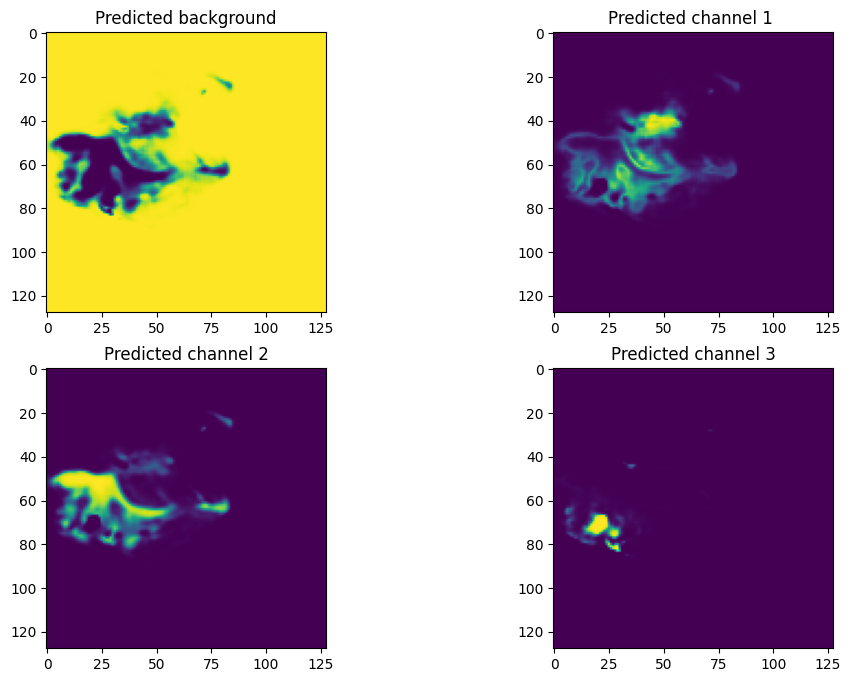

In [19]:
y_pred = np.reshape(y_pred, (VOLUME_SLICES, IMG_SIZE, IMG_SIZE, CLASSES))

plt.figure(figsize=(12, 8))
plt.subplot(221)
plt.imshow(y_pred[n_slice, :, :, 0])
plt.title('Predicted background')
plt.subplot(222)
plt.imshow(y_pred[n_slice, :, :, 1])
plt.title('Predicted channel 1 ')
plt.subplot(223)
plt.imshow(y_pred[n_slice, :, :, 2])
plt.title('Predicted channel 2')
plt.subplot(224)
plt.imshow(y_pred[n_slice, :, :, 3])
plt.title('Predicted channel 3')
plt.show()

### Show the mask on each channel

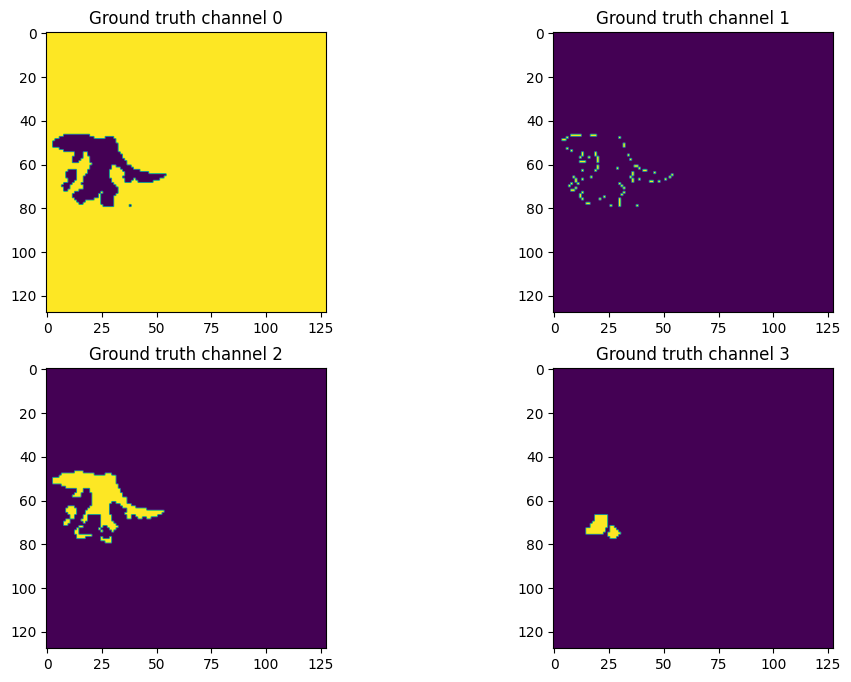

In [20]:
plt.figure(figsize=(12, 8))
plt.subplot(221)
plt.imshow(y_test[n_slice, :, :, 0])
plt.title('Ground truth channel 0')
plt.subplot(222)
plt.imshow(y_test[n_slice, :, :, 1])
plt.title('Ground truth channel 1')
plt.subplot(223)
plt.imshow(y_test[n_slice, :, :, 2])
plt.title('Ground truth channel 2')
plt.subplot(224)
plt.imshow(y_test[n_slice, :, :, 3])
plt.title('Ground truth channel 3')
plt.show()